In [6]:
import math
import csv
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

class AnomalyDetection:
    def __init__(self, measurement_err=1, model_err=1):
        self.measurement_error = measurement_err
        self.estimation_error = measurement_err
        self.model_error = model_err
        self.current_estimate = 0  
        self.last_estimate = 230 #mean value
        self.gain = 0
        self.mahalanobis_distance = 0
        self.forgetting_factor = 0.2
        self.shape_param = 0.6
        self.estimate = []



#The Mahalanobis distance is used to quantify the difference between the measurements and the estimates.
#The Mahalanobis distance is a measure of the distance between the measurement and the estimated state, taking into account the uncertainty in the estimation.

    def update_detection(self, measurement):
        
        self.gain = self.estimation_error / (self.estimation_error + self.measurement_error)
        self.current_estimate = self.last_estimate + self.gain * (measurement - self.last_estimate)
        self.estimation_error = (1.0 - self.gain) * self.estimation_error + abs(self.last_estimate - self.current_estimate) * self.model_error
        self.last_estimate = self.current_estimate
        
        self.estimate.append(self.last_estimate)
        #print(self.estimate)
        self.mahalanobis_distance = (self.mahalanobis_distance * self.forgetting_factor) + ((1 - self.forgetting_factor) * math.sqrt(((measurement - self.last_estimate) * (measurement - self.last_estimate)) / self.estimation_error))
        return 1 / (1 + math.exp(-self.mahalanobis_distance + self.shape_param))
    
    




In [13]:

def read_csv_file(file_path):
    timestamps = []
    voltage_data = []
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)  # Skip header row
        for row in csvreader:
            timestamp, voltage = row
            timestamps.append(timestamp)
            voltage_data.append(float(voltage))
    return timestamps, voltage_data


# def plot_anomaly_scores(timestamps, anomaly_scores):
#     # Convert timestamps to datetime objects for better plotting
#     datetimes = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

#     plt.figure(figsize=(12, 6))
#     plt.plot(datetimes, anomaly_scores, marker='o', linestyle='-', color='b')
#     plt.xlabel('Timestamp')
#     plt.ylabel('Anomaly Score')
#     plt.title('Anomaly Detection Results')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


def plot_anomaly_scores(timestamps, anomaly_scores):
    # Convert timestamps to datetime objects for better plotting
    datetimes = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]
    
    # Create a figure and axis
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    
    # Plot the anomaly scores as a line plot
    ax.plot(datetimes, anomaly_scores, marker='o', linestyle='-', color='b', label='Anomaly Score')
    
    # Highlight anomalies with scores greater than 0.8
    for i, score in enumerate(anomaly_scores):
        if score > 0.8:
            ax.scatter(datetimes[i], score, color='red', s=100, label='Anomaly' if i == 0 else "")
    
    # Set labels and title
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Anomaly Score')
    ax.set_title('Anomaly Detection Results')
    
    # Add legend
    ax.legend()
    
    # Display grid
    ax.grid(True)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [14]:
def plot_estimate_vs_measurement(timestamps, measurement_data, last_estimates):
    # Convert timestamps to datetime objects for better plotting
    datetimes = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

    plt.figure(figsize=(12, 6))
    plt.plot(datetimes, measurement_data, label='Measurement Data', marker='o', linestyle='-', color='blue')
    plt.plot(datetimes, last_estimates, label='Estimated voltage', marker='x', linestyle='--', color='red')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Estimate vs Measurement')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Timestamp: 2023-07-24 08:00:00, Anomaly Score: 0.43375852516114655
Timestamp: 2023-07-24 09:00:00, Anomaly Score: 0.4600253456338933
Timestamp: 2023-07-24 10:00:00, Anomaly Score: 0.550838464795922
Timestamp: 2023-07-24 11:00:00, Anomaly Score: 0.8799120915000144
Timestamp: 2023-07-24 12:00:00, Anomaly Score: 0.6110544141631254
Timestamp: 2023-07-24 13:00:00, Anomaly Score: 0.6567400168039846
Timestamp: 2023-07-24 14:00:00, Anomaly Score: 0.5538853129402863
Timestamp: 2023-07-24 15:00:00, Anomaly Score: 0.3988294892575425
Timestamp: 2023-07-24 16:00:00, Anomaly Score: 0.5317209577370564
Timestamp: 2023-07-24 17:00:00, Anomaly Score: 0.587862242532767
Timestamp: 2023-07-24 18:00:00, Anomaly Score: 0.4909746910954468
Timestamp: 2023-07-24 19:00:00, Anomaly Score: 0.4686535556408255
Timestamp: 2023-07-24 20:00:00, Anomaly Score: 0.5982251460621462
Timestamp: 2023-07-24 21:00:00, Anomaly Score: 0.4185012851314247
Timestamp: 2023-07-24 22:00:00, Anomaly Score: 0.7115186990891328
Timestamp: 

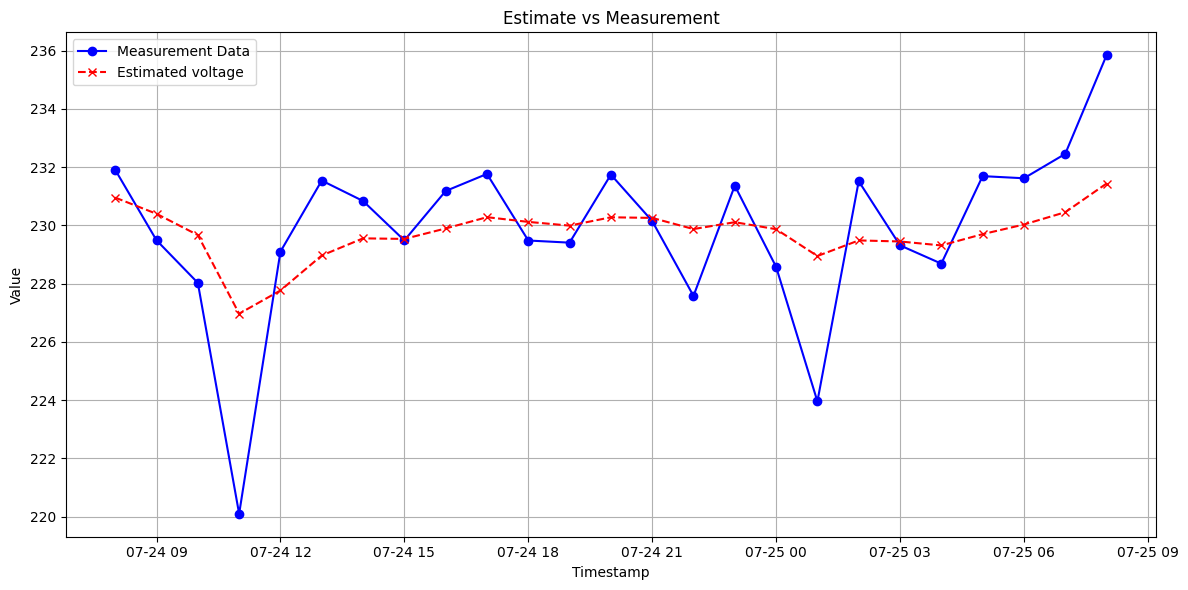

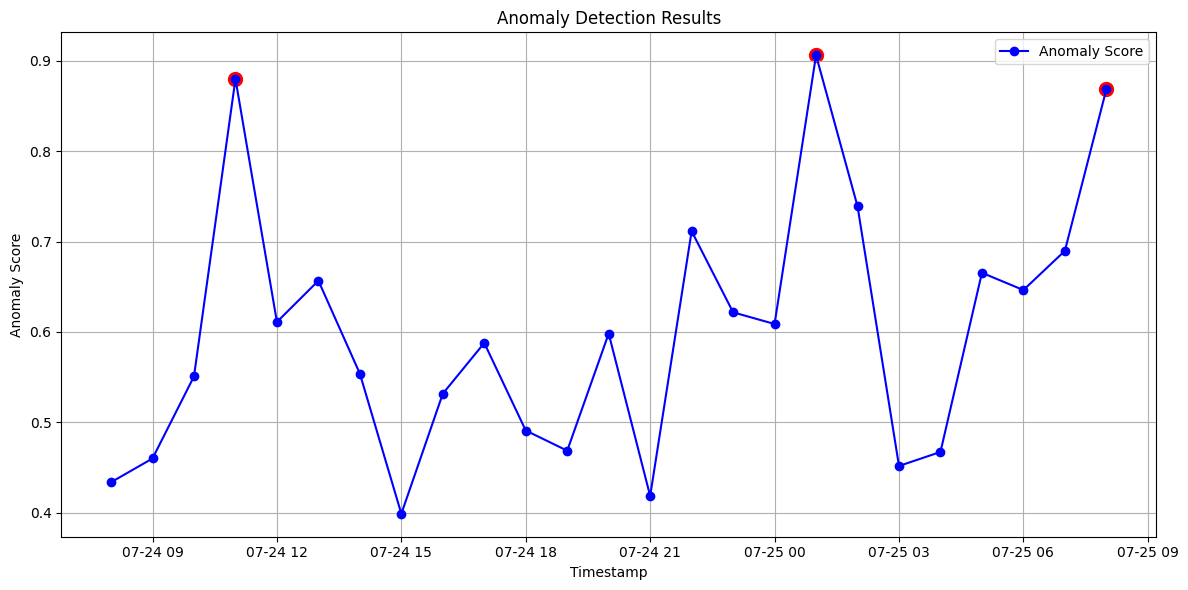

Variance of the voltage data: 8.567696449914196


In [16]:
if __name__ == "__main__":
    file_path = 'dummy_voltage_data_with_anomalies.csv'
    timestamps, voltage_data = read_csv_file(file_path)

    # Assuming measurement error is 5.6 which is the variance of the measurement
    # If the Measurement error, R is larger than the modal error, Q. In other words, we are punishing the measurement error, R more which results the algorithm to trust the new measurement less and modal error more.

    anomaly_detector = AnomalyDetection(measurement_err=8.56, model_err=1)   # (measurement_err=5.6, model_err=0.1)

    # Detect anomalies in the voltage data
    anomaly_scores = [anomaly_detector.update_detection(voltage) for voltage in voltage_data]

   
   # Create lists to store the Kalman filter estimates (last_estimate)
    estimated_voltage = []
    
    for voltage in voltage_data:
        estimated_voltage = anomaly_detector.estimate
        
        
        #print('estimated voltages are:',estimated_voltage)
   

    # Print the timestamp and anomaly score for each data point
    for timestamp, score in zip(timestamps, anomaly_scores):
        print(f"Timestamp: {timestamp}, Anomaly Score: {score}")


    # Visualize the estimate values of kalman filter against the measurement data
    plot_estimate_vs_measurement(timestamps, voltage_data, estimated_voltage)


    # Visualize the anomaly scores
    plot_anomaly_scores(timestamps, anomaly_scores)

    # Calculate the variance of the voltage data
    variance = np.var(voltage_data)

    print("Variance of the voltage data:", variance)
